# Imports

In [25]:
import os
import sys
import time

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import yaml

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader
from tqdm import tqdm

sys.path.append(os.path.abspath(os.path.join('..')))

import init_training
import local_datasets

# Setup

In [2]:
# change working directory if not /home/mappel/Dynaphos/viseon
if os.getcwd().split("/")[-1] != "viseon":
    os.chdir("/home/mappel/Dynaphos/viseon")

In [3]:
def load_config(yaml_file):
    with open(yaml_file) as file:
        raw_content = yaml.load(file,Loader=yaml.FullLoader) # nested dictionary
    return {k:v for params in raw_content.values() for k,v in params.items()} # unpacked

experiment_yaml = [ './_config/exp1-snellius/128x128_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov64x64_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov32x32_contrained_boundary.yaml',
                    './_config/exp1-snellius/lin16x16_contrained_boundary.yaml',
                    './_config/exp1-snellius/fov16x16_contrained_boundary.yaml']

# load configs into dict
config = [load_config(yaml_file) for yaml_file in experiment_yaml]
config = {key: value for key, value in zip(['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov'], config)}

# Front facing images
For our behavioural experiment it is important that we use front facing images only, to get rid of the position information when the participants are distinguishing faces.

In [4]:
# Get the entire test set for 128x128 images
cfg = config['128x128']
cfg['imsize'] = [256, 256]
cfg['batch_size'] = 1
cfg['circular_mask'] = None
cfg['target'] = 'semantic'
cfg['data_directory'] = '../data/face/LaPa/'

testset_all = local_datasets.get_lapa_dataset(cfg, split='test')


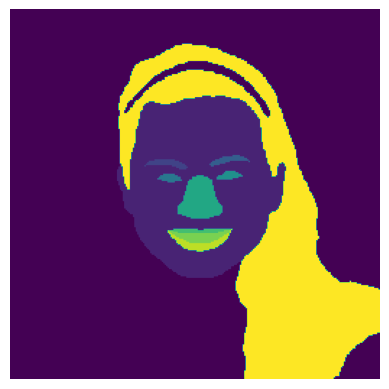

In [5]:
# 0 = background
# 1 = face
# 2 = right eyebrow
# 3 = left eyebrow
# 4 = right eye
# 5 = left eye
# 6 = nose
# 7 = upper lip
# 8 = mouth
# 9 = lower lip
# 10 = hair

plt.imshow(testset_all[2]['segmentation_maps'].cpu().detach().numpy())
plt.axis('off')
plt.show()

In [6]:
# calculate mean and std of face area for all images

def calculate_face_area(segmentation_map):
    return np.sum(segmentation_map[segmentation_map == 1])/segmentation_map.shape[0]/segmentation_map.shape[1]

face_areas = []
for i in range(len(testset_all)):
    face_areas.append(calculate_face_area(testset_all[i]['segmentation_maps'].cpu().detach().numpy()))

face_areas = np.array(face_areas)
face_areas.mean(), face_areas.std()

(0.1668396987915039, 0.05103337174026832)

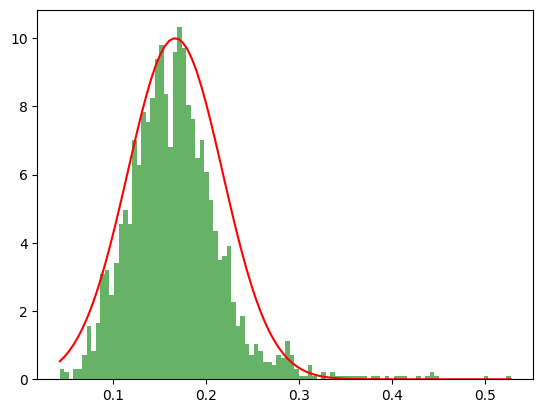

In [7]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

plt.hist(face_areas, bins=100, density=True, alpha=0.6, color='g')

mu = face_areas.mean()
sigma = face_areas.std()
x = np.linspace(face_areas.min(), face_areas.max(), 100)
plt.plot(x, 10*gaussian(x, mu, sigma), color='r')
plt.show()

In [8]:
# Find the most centered faces
def calculate_center_score(segmentation_map_example):
    # Extract the face area
    face_mask = (segmentation_map_example == 1).float().cpu().detach().numpy()
    face_pixels = np.where(face_mask > 0)
    min_x, max_x = face_pixels[1].min(), face_pixels[1].max()
    min_y, max_y = face_pixels[0].min(), face_pixels[0].max()

    # Calculate the center of the face
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2

    # Calculate the distance from the center to the edges
    distance_x = min(center_x, 256 - center_x)
    distance_y = min(center_y, 256 - center_y)

    # Calculate the score
    score = min(distance_x, distance_y) / 128

    return score

def symmetry_score(segmentation_map_example, resize_dim=128):
    # Convert to one hot encoding for categories: background, face, eyes, eyebrows, nose, upper lip, mouth, lower lip, hair
    one_hot = torch.zeros(5, 256, 256)
    one_hot[0] = (segmentation_map_example == 2).float() + (segmentation_map_example == 3).float()  # eyebrows
    one_hot[1] = (segmentation_map_example == 4).float() + (segmentation_map_example == 5).float()  # eyes
    one_hot[2] = (segmentation_map_example == 6).float()  # nose
    one_hot[3] = (segmentation_map_example == 7).float()  # upper lip
    one_hot[4] = (segmentation_map_example == 9).float()  # lower lip
    # one_hot[5] = (segmentation_map_example == 1).float()  # face

    face_area = (segmentation_map_example == 1).float().sum(0).sum(0) / 256**2
    center_score = calculate_center_score(segmentation_map_example)
    
    # if any of the categories are not present, return 0
    if False in (one_hot.sum(1).sum(1) > 0):
        return 0.0, face_area.item(), center_score.item()

    # Extract the face area
    face_mask = (segmentation_map_example == 1).float().cpu().detach().numpy()
    face_pixels = np.where(face_mask > 0)
    min_x, max_x = face_pixels[1].min(), face_pixels[1].max()
    min_y, max_y = face_pixels[0].min(), face_pixels[0].max()

    # Crop and resize face region to a standard dimension
    face_region = face_mask[min_y:max_y, min_x:max_x]
    face_resized = cv2.resize(face_region, (resize_dim, resize_dim), interpolation=cv2.INTER_NEAREST_EXACT)

    # Split resized face in half for symmetry check
    face_left = face_resized[:, :resize_dim // 2]
    face_right = cv2.flip(face_resized[:, resize_dim // 2:], 1)

    # Check for symmetry with SSIM (assuming you have a suitable SSIM function for grayscale)
    ssim_score = ssim(face_left, face_right, data_range=1)  # Modify `data_range` if using another scale

    return ssim_score.item(), face_area.item(), center_score.item()

In [9]:
symmetry_scores = []
face_areas = []
center_scores = []

for i in range(2000):
    symmetry_score_, face_area_, center_score_ = symmetry_score(testset_all[i]['segmentation_maps'])
    symmetry_scores.append(symmetry_score_)
    face_areas.append(face_area_)
    center_scores.append(center_score_)

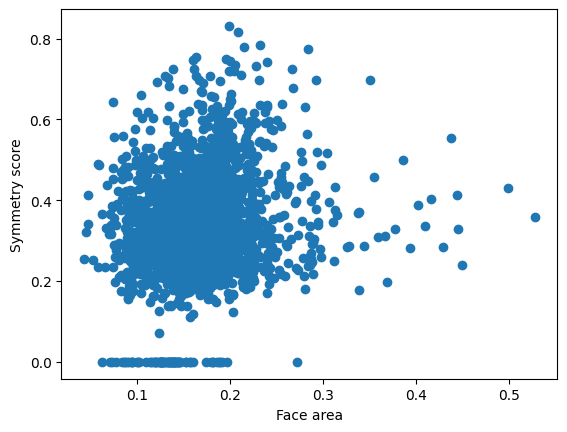

[[1.         0.16280404]
 [0.16280404 1.        ]]


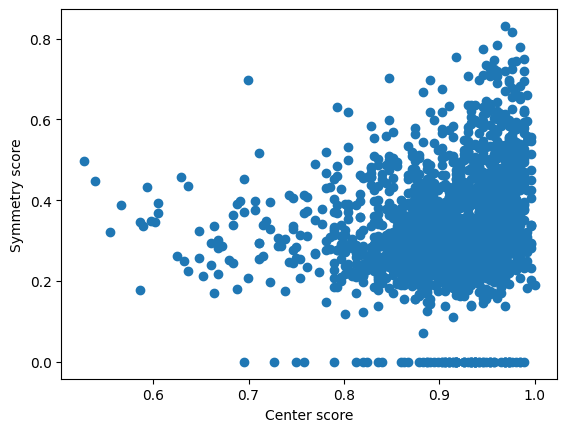

[[1.         0.18773623]
 [0.18773623 1.        ]]


In [10]:
symmetry_scores_ = np.array(symmetry_scores)
face_areas_ = np.array(face_areas)
center_scores_ = np.array(center_scores)

# plot the scores
plt.scatter(face_areas_, symmetry_scores_)
plt.xlabel('Face area')
plt.ylabel('Symmetry score')
plt.show()

# correlation between face area and symmetry score
print(np.corrcoef(face_areas_, symmetry_scores_))

# plot the scores
plt.scatter(center_scores_, symmetry_scores_)
plt.xlabel('Center score')
plt.ylabel('Symmetry score')
plt.show()

# correlation between center score and symmetry score
print(np.corrcoef(center_scores_, symmetry_scores_))

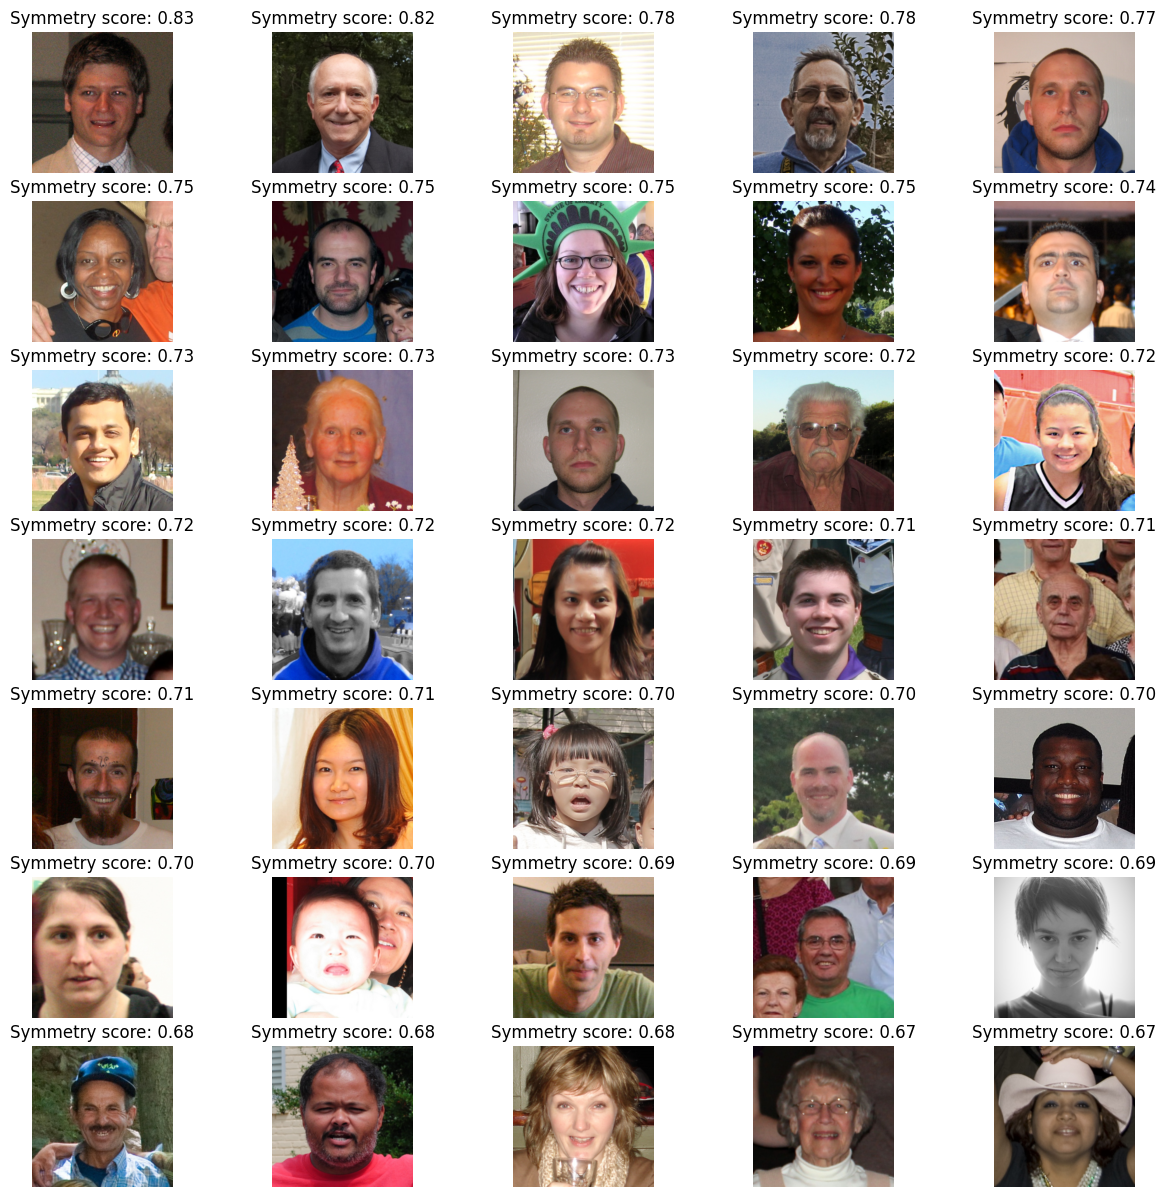

In [26]:
# find the 30 most symmetric images

symmetry_scores = np.array(symmetry_scores)
indices = np.argsort(symmetry_scores)
# flip list
indices = indices[::-1]
idx = indices[:35]

# plot
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(7, 5, figure=fig)
for i in range(35):
    ax = fig.add_subplot(gs[i])
    ax.imshow(testset_all[idx[i]]['image'].permute(1,2,0).cpu().detach().numpy())
    ax.set_title(f"Symmetry score: {symmetry_scores[idx[i]]:.2f}")
    # line through the middle
    # ax.axvline(64, color='r')
    ax.axis('off')
plt.show()


In [27]:
def zoom_to_face_area(segmentation_map, image, mu):
    # Extract the face area
    face_mask = (segmentation_map == 1).astype(np.float32)
    face_pixels = np.where(face_mask > 0)
    min_x, max_x = face_pixels[1].min(), face_pixels[1].max()
    min_y, max_y = face_pixels[0].min(), face_pixels[0].max()

    # Calculate the current face area
    current_face_area = np.sum(face_mask) / (segmentation_map.shape[0] * segmentation_map.shape[1])

    # Calculate the scaling factor
    scaling_factor = np.sqrt(mu / current_face_area)

    # Resize the image and segmentation map
    new_size = (int(image.shape[1] * scaling_factor), int(image.shape[0] * scaling_factor))
    resized_image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR)
    resized_face_mask = cv2.resize(face_mask, new_size, interpolation=cv2.INTER_LINEAR)

    # Find the new face bounding box in the resized image
    resized_face_pixels = np.where(resized_face_mask > 0)
    new_min_x, new_max_x = resized_face_pixels[1].min(), resized_face_pixels[1].max()
    new_min_y, new_max_y = resized_face_pixels[0].min(), resized_face_pixels[0].max()

    # Calculate the center of the face in the resized image
    center_x = (new_min_x + new_max_x) // 2
    center_y = (new_min_y + new_max_y) // 2

    # Define the target center of the output image
    target_center_x = image.shape[1] // 2
    target_center_y = image.shape[0] // 2

    # Calculate where to crop in the resized image to center the face
    start_x = max(0, center_x - target_center_x)
    start_y = max(0, center_y - target_center_y)
    end_x = min(new_size[0], start_x + image.shape[1])
    end_y = min(new_size[1], start_y + image.shape[0])

    # Crop the resized image around the face
    cropped_resized_image = resized_image[start_y:end_y, start_x:end_x]

    # Create the output image with the original dimensions
    centered_image = np.zeros_like(image) #+ 0.5

    # Calculate where to place the cropped face in the output image
    paste_x_start = max(0, target_center_x - center_x)
    paste_y_start = max(0, target_center_y - center_y)
    paste_x_end = min(centered_image.shape[1], paste_x_start + cropped_resized_image.shape[1])
    paste_y_end = min(centered_image.shape[0], paste_y_start + cropped_resized_image.shape[0])

    # Adjust the dimensions of cropped_resized_image if it doesn't fit in centered_image
    cropped_resized_image = cropped_resized_image[:paste_y_end - paste_y_start, :paste_x_end - paste_x_start]

    # Paste the cropped image into the centered output image
    centered_image[paste_y_start:paste_y_end, paste_x_start:paste_x_end] = cropped_resized_image

    return centered_image

In [28]:
def create_circular_mask(h, w, center=None, radius=None):
# should also work for RGB images
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius

    return mask

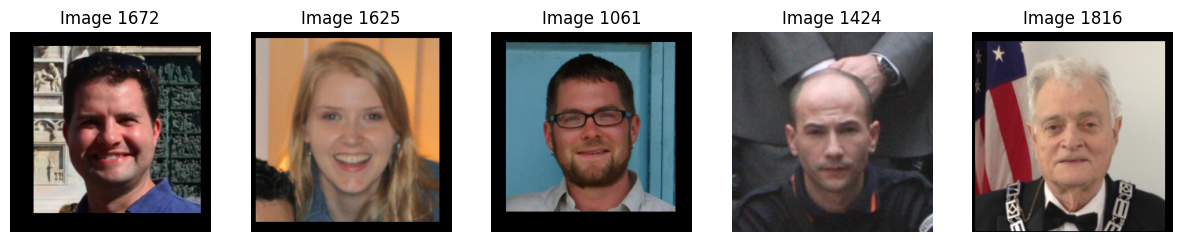

In [29]:
# 1. Find the 50 most symmetric images
symmetry_scores_with_exclusions = np.array(symmetry_scores)
# exclude 53, 317, 580, 616, 938, 1017, 1325, 1945
exclusions = [53, 286, 317, 580, 616, 751, 938, 956, 1017, 1541, 1325, 1945, 1121, 1123, 1270]
for i in exclusions:
    symmetry_scores_with_exclusions[i] = 0
    
indices_symmetry = np.argsort(symmetry_scores_with_exclusions)[::-1]
idx_symmetry = indices_symmetry[30:35]

# 2. Use zoom_to_face_area to transform them
zoomed_images = []
for i in idx_symmetry:
    image = testset_all[i]['image'].permute(1,2,0).cpu().detach().numpy()
    segmentation_map = testset_all[i]['segmentation_maps'].cpu().detach().numpy()
    image = zoom_to_face_area(segmentation_map, image, mu)
    zoomed_images.append(image)

# Add a circular mask to the images using create_circular_mask

# for i in range(len(images)):
#     mask = create_circular_mask(128, 128, center=(64, 64), radius=64)
#     images[i] = images[i] * mask.repeat(3).reshape(128, 128, 3)


# Plot
fig = plt.figure(figsize=(15, 15))
gs = GridSpec(1, 5, figure=fig)
for i in range(5):
    ax = fig.add_subplot(gs[i])
    ax.imshow(zoomed_images[i])
    # place a red cross over the center
    # ax.axvline(zoomed_images[i].shape[1] // 2, color='r')
    # ax.axhline(zoomed_images[i].shape[0] // 2, color='r')

    # title image idx
    ax.set_title(f"Image {idx_symmetry[i]}")
    
    ax.axis('off')
plt.show()

In [33]:
len(zoomed_images)

5

In [34]:
# save the zoomed images
folder_name_zoomed = f"../data/LaPa_testtrial/test/images"

# make folder
os.makedirs(folder_name_zoomed, exist_ok=True)

for i in range(len(zoomed_images)):
    plt.imsave(f"{folder_name_zoomed}/{i}_image{idx_symmetry[i]}.jpg", zoomed_images[i])

In [39]:
# Use these 30 images to create phosphene images for each architecture

# Configuration

cfg = config['128x128']
cfg['imsize'] = [128, 128]
cfg['batch_size'] = 1
cfg['target'] = 'boundary'
cfg['data_directory'] = f"../data/LaPa_testtrial"

# Define the architectures you want to use
architectures = list(config.keys())

folder_name = f"behavioral_experiment_data_testtrial"
# make folder
os.makedirs(folder_name, exist_ok=True)

# loop through architectures
for experiment in architectures:
    cfg = config[experiment]
    cfg['data_directory'] = f"../data/LaPa_testtrial"
    cfg['batch_size'] = 1
    cfg['circular_mask'] = True

    # make a dataset with the zoomed images
    training_pipeline = init_training.get_training_pipeline(cfg)
    models = init_training.get_models(cfg)
    np.random.seed(42)
    testset_zoomed = local_datasets.get_lapa_dataset(cfg, split='test')
    # sort image paths on first number
    testset_zoomed.image_paths = sorted(testset_zoomed.image_paths, key=lambda x: int(x.split('/')[-1].split('_')[0]))
    testset_zoomed.label_paths = [None] * 5

    np.random.seed(42)

    # Load pre-trained encoder and decoder
    models['encoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_encoder.pth'))
    models['decoder'].load_state_dict(torch.load(cfg['save_path'] + 'checkpoints/final_decoder.pth'))

    forward = training_pipeline['forward']

    for i, batch in enumerate(testset_zoomed):
        # Prepare the batch for the selected ground truth image
        input_batch = batch
        input_batch['image'] = input_batch['image'].unsqueeze(0)
        input_batch['contour'] = torch.zeros(1, 1, 256, 256).cuda()

        # Run the model forward pass
        model_output = forward(input_batch, models, cfg)
        phosphene_image = model_output['phosphenes'][0][0].cpu().detach().numpy()
        
        phosphene_path = f"{folder_name}/{i}_image{idx_symmetry[i]}_{experiment}_phosphene.png"
        plt.imsave(phosphene_path, phosphene_image, cmap='gray')

        if experiment == '128x128':
            input_path = f"{folder_name}/{i}_image{idx_symmetry[i]}_input.png"
            plt.imsave(input_path, zoomed_images[i])


In [37]:
# rename nea to lin in architectures
architectures = ['128x128', '64x64lin', '64x64fov', '32x32lin', '32x32fov', '16x16lin', '16x16fov']

titles = ['128x128', '64x64 nearest', '64x64 fov', '32x32 nearest', '32x32 fov', '16x16 nearest', '16x16 fov']

In [ ]:

# load the images and show them in a grid
folder_name = f"behavioral_experiment_data_testtrial"
# get all image files in the folder
files = os.listdir(folder_name)
# only png files
files = [f for f in files if f.endswith('.png')]
# sort by number, not alphabetically
files.sort(key=lambda x: int(x.split('_')[0]))

# filter out the phosphene images
phosphenes = [f for f in files if 'phosphene' in f]
inputs = [f for f in files if 'input' in f]

# show the first 5 inputs with the 7 phosphene images [input, 128x128, 64x64lin, 64x64fov, 32x32lin, 32x32fov, 16x16lin, 16x16fov]
# plot
fig = plt.figure(figsize=(22, 14))
# tight layout
plt.tight_layout()

gs = GridSpec(5, 8, figure=fig)

# pick random 5 indices
np.random.seed(3)
indices = np.random.choice(30, 5, replace=False)

for i, k in enumerate(indices):
    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(plt.imread(f"{folder_name}/{k}_image{idx_symmetry[k]}_input.png"))
    ax.axis('off')

    for j in range(7):
        ax = fig.add_subplot(gs[i, j+1])
        if i == 0:
            # title of input size
            ax.set_title(titles[j])
        ax.imshow(plt.imread(f"{folder_name}/{k}_image{idx_symmetry[k]}_{architectures[j]}_phosphene.png"), cmap='gray')
        ax.axis('off')

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'behavioral_experiment_data_testtrial'

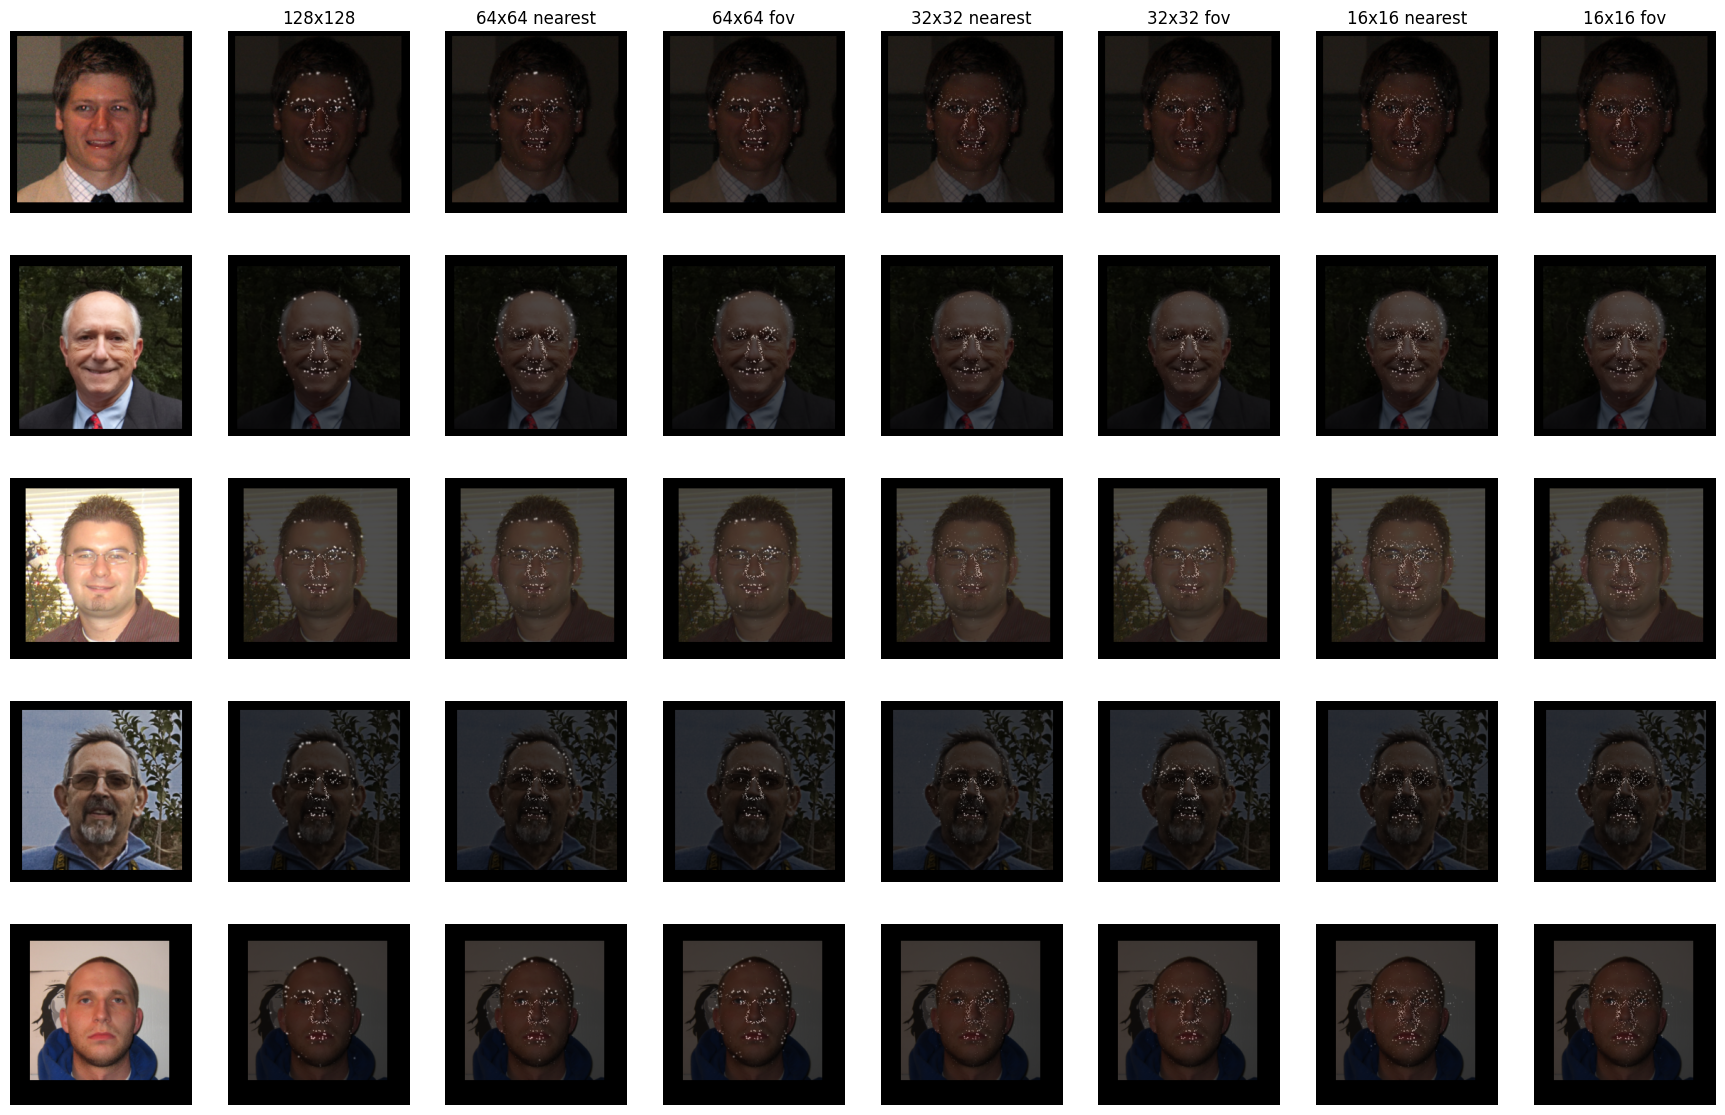

In [17]:
# plot an overlay image of the input and phosphene images
# plot
fig = plt.figure(figsize=(22, 14))
# tight layout
plt.tight_layout()

gs = GridSpec(5, 8, figure=fig)

# pick random 5 indices
np.random.seed(3)
indices = [0,1,2,3,4]

for i, k in enumerate(indices):
    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(plt.imread(f"{folder_name}/{k}_image{idx_symmetry[k]}_input.png"))
    ax.axis('off')

    for j in range(7):
        ax = fig.add_subplot(gs[i, j+1])
        if i == 0:
            # title of input size
            ax.set_title(titles[j])
        ax.imshow(plt.imread(f"{folder_name}/{k}_image{idx_symmetry[k]}_input.png"))
        ax.imshow(plt.imread(f"{folder_name}/{k}_image{idx_symmetry[k]}_{architectures[j]}_phosphene.png"), cmap='gray', alpha=0.7)
        ax.axis('off')

plt.show()

In [39]:
# Create a csv file with the image paths with headers [id,input_size,target_id,input2_id,input3_id,input4_id,input5_id,input6_id,input7_id,input8_id,phosphene_path,target_path,input2_path,input3_path,input4_path,input5_path,input6_path,input7_path,input8_path]
# Each phosphene image should have a corresponding target image and 7 random distractor images
# The ids are the first index of the file names

np.random.seed(42)

# create a dataframe
df = pd.DataFrame(columns=['id', 'input_size', 'target_id', 'input2_id', 'input3_id', 'input4_id', 'input5_id', 'input6_id', 'input7_id', 'input8_id', 'phosphene_path', 'target_path', 'input2_path', 'input3_path', 'input4_path', 'input5_path', 'input6_path', 'input7_path', 'input8_path'])

# get all image files in the folder
files = os.listdir(folder_name)
# only png files
files = [f for f in files if f.endswith('.png')]
# sort by number, not alphabetically
files.sort(key=lambda x: int(x.split('_')[0]))

# filter out the phosphene images
phosphenes = [f for f in files if 'phosphene' in f]
inputs = [f for f in files if 'input' in f]

# loop through the phosphene images

id = 0
for i, phosphene_path in enumerate(phosphenes):
    # get the id
    id_ = int(phosphene_path.split('_')[0])
    # get the input size
    input_size = phosphene_path.split('_')[2]
    # get the target id
    target_id = id_

    # get the target path
    target_path = f"{folder_name}/{id_}_image{idx_symmetry[id_]}_input.png"
    
    # Choose 7 random distractor images
    # exclude the target id
    distractors = np.random.choice([i for i in range(30) if i != id_], 7, replace=False)   
    
    # get the paths
    distractor_paths = [f"{folder_name}/{distractor}_image{idx_symmetry[distractor]}_input.png" for distractor in distractors]

    # use loc
    row = [id, input_size, target_id] + distractors.tolist() + [f"{folder_name}/{phosphene_path}", target_path] + distractor_paths
    df.loc[i] = row

    id += 1

df

,id,input_size,target_id,input2_id,input3_id,input4_id,input5_id,input6_id,input7_id,input8_id,phosphene_path,target_path,input2_path,input3_path,input4_path,input5_path,input6_path,input7_path,input8_path
0,0,16x16fov,0,28,17,13,23,9,10,22,behavioral_experiment_data/0_image1408_16x16fo...,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/28_image1428_input.png,behavioral_experiment_data/17_image935_input.png,behavioral_experiment_data/13_image1836_input.png,behavioral_experiment_data/23_image1681_input.png,behavioral_experiment_data/9_image658_input.png,behavioral_experiment_data/10_image188_input.png,behavioral_experiment_data/22_image1293_input.png
1,1,16x16lin,0,1,6,21,26,14,8,23,behavioral_experiment_data/0_image1408_16x16li...,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/1_image1104_input.png,behavioral_experiment_data/6_image1422_input.png,behavioral_experiment_data/21_image1145_input.png,behavioral_experiment_data/26_image1578_input.png,behavioral_experiment_data/14_image72_input.png,behavioral_experiment_data/8_image757_input.png,behavioral_experiment_data/23_image1681_input.png
2,2,32x32fov,0,5,25,11,1,9,20,29,behavioral_experiment_data/0_image1408_32x32fo...,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/5_image835_input.png,behavioral_experiment_data/25_image1582_input.png,behavioral_experiment_data/11_image1692_input.png,behavioral_experiment_data/1_image1104_input.png,behavioral_experiment_data/9_image658_input.png,behavioral_experiment_data/20_image1261_input.png,behavioral_experiment_data/29_image797_input.png
3,3,32x32lin,0,4,2,5,6,17,26,10,behavioral_experiment_data/0_image1408_32x32li...,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/4_image581_input.png,behavioral_experiment_data/2_image1744_input.png,behavioral_experiment_data/5_image835_input.png,behavioral_experiment_data/6_image1422_input.png,behavioral_experiment_data/17_image935_input.png,behavioral_experiment_data/26_image1578_input.png,behavioral_experiment_data/10_image188_input.png
4,4,64x64lin,0,15,4,28,20,25,22,10,behavioral_experiment_data/0_image1408_64x64li...,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/15_image1925_input.png,behavioral_experiment_data/4_image581_input.png,behavioral_experiment_data/28_image1428_input.png,behavioral_experiment_data/20_image1261_input.png,behavioral_experiment_data/25_image1582_input.png,behavioral_experiment_data/22_image1293_input.png,behavioral_experiment_data/10_image188_input.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,205,16x16fov,29,5,4,19,0,13,17,21,behavioral_experiment_data/29_image797_16x16fo...,behavioral_experiment_data/29_image797_input.png,behavioral_experiment_data/5_image835_input.png,behavioral_experiment_data/4_image581_input.png,behavioral_experiment_data/19_image928_input.png,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/13_image1836_input.png,behavioral_experiment_data/17_image935_input.png,behavioral_experiment_data/21_image1145_input.png
206,206,64x64fov,29,14,28,13,15,24,0,8,behavioral_experiment_data/29_image797_64x64fo...,behavioral_experiment_data/29_image797_input.png,behavioral_experiment_data/14_image72_input.png,behavioral_experiment_data/28_image1428_input.png,behavioral_experiment_data/13_image1836_input.png,behavioral_experiment_data/15_image1925_input.png,behavioral_experiment_data/24_image1832_input.png,behavioral_experiment_data/0_image1408_input.png,behavioral_experiment_data/8_image757_input.png
207,207,128x128,29,11,18,17,1,7,28,12,behavioral_experiment_data/29_image797_128x128...,behavioral_experiment_data/29_image797_input.png,behavioral_experiment_data/11_image1692_input.png,behavioral_experiment_data/18_image1965_input.png,behavioral_experiment_data/17_image935_input.png,behavioral_experiment_data/1_image1104_input.png,behavioral_experiment_data/7_i

In [40]:
 
# save the dataframe
df.to_csv(f"{folder_name}/behavioral_experiment_data.csv", index=False)

In [38]:
# Now lets make a small subset set with 10 faces and only 1 architecture 128x128, copy from the original behavioral_experiment_data folder

# copy the images into a new folder
folder_name_subset = f"{folder_name}_subset"
# make folder
os.makedirs(folder_name_subset, exist_ok=True)

# copy the images
for i in range(10):
    # copy the input image
    os.system(f"cp {folder_name}/{i}_image{idx_symmetry[i]}_input.png {folder_name_subset}")
    # copy the phosphene image
    os.system(f"cp {folder_name}/{i}_image{idx_symmetry[i]}_128x128_phosphene.png {folder_name_subset}")



In [41]:
# make a dataframe with the subset: only 10 faces and where input_size = 128x128

# create a dataframe
df_subset = pd.DataFrame(columns=['id', 'input_size', 'target_id', 'input2_id', 'input3_id', 'input4_id', 'input5_id', 'input6_id', 'input7_id', 'input8_id', 'phosphene_path', 'target_path', 'input2_path', 'input3_path', 'input4_path', 'input5_path', 'input6_path', 'input7_path', 'input8_path'])

# get all image files in the folder
files = os.listdir(folder_name_subset)
# only png files
files = [f for f in files if f.endswith('.png')]
# sort by number, not alphabetically
files.sort(key=lambda x: int(x.split('_')[0]))

# filter out the phosphene images
phosphenes = [f for f in files if 'phosphene' in f]
inputs = [f for f in files if 'input' in f]

# loop through the phosphene images

id = 0
for i, phosphene_path in enumerate(phosphenes):
    # get the id
    id_ = int(phosphene_path.split('_')[0])
    # get the input size
    input_size = phosphene_path.split('_')[2]
    # get the target id
    target_id = id_

    # get the target path
    target_path = f"{folder_name_subset}/{id_}_image{idx_symmetry[id_]}_input.png"
    
    # Choose 7 random distractor images
    # exclude the target id
    distractors = np.random.choice([i for i in range(10) if i != id_], 7, replace=False)   
    
    # get the paths
    distractor_paths = [f"{folder_name_subset}/{distractor}_image{idx_symmetry[distractor]}_input.png" for distractor in distractors]

    # use loc
    row = [id, input_size, target_id] + distractors.tolist() + [f"{folder_name_subset}/{phosphene_path}", target_path] + distractor_paths
    df_subset.loc[i] = row

    id += 1

df_subset


,id,input_size,target_id,input2_id,input3_id,input4_id,input5_id,input6_id,input7_id,input8_id,phosphene_path,target_path,input2_path,input3_path,input4_path,input5_path,input6_path,input7_path,input8_path
0,0,128x128,0,8,1,4,5,3,9,2,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/4_image581_i...,behavioral_experiment_data_subset/5_image835_i...,behavioral_experiment_data_subset/3_image1416_...,behavioral_experiment_data_subset/9_image658_i...,behavioral_experiment_data_subset/2_image1744_...
1,1,128x128,1,3,2,0,5,4,6,9,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/3_image1416_...,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/5_image835_i...,behavioral_experiment_data_subset/4_image581_i...,behavioral_experiment_data_subset/6_image1422_...,behavioral_experiment_data_subset/9_image658_i...
2,2,128x128,2,3,1,8,6,4,9,5,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/3_image1416_...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experiment_data_subset/6_image1422_...,behavioral_experiment_data_subset/4_image581_i...,behavioral_experiment_data_subset/9_image658_i...,behavioral_experiment_data_subset/5_image835_i...
3,3,128x128,3,2,7,1,0,8,5,6,behavioral_experiment_data_subset/3_image1416_...,behavioral_experiment_data_subset/3_image1416_...,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/7_image910_i...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experiment_data_subset/5_image835_i...,behavioral_experiment_data_subset/6_image1422_...
4,4,128x128,4,1,2,6,0,8,9,3,behavioral_experiment_data_subset/4_image581_1...,behavioral_experiment_data_subset/4_image581_i...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/6_image1422_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experiment_data_subset/9_image658_i...,behavioral_experiment_data_subset/3_image1416_...
5,5,128x128,5,4,8,1,0,2,9,6,behavioral_experiment_data_subset/5_image835_1...,behavioral_experiment_data_subset/5_image835_i...,behavioral_experiment_data_subset/4_image581_i...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/9_image658_i...,behavioral_experiment_data_subset/6_image1422_...
6,6,128x128,6,8,1,0,5,9,3,7,behavioral_experiment_data_subset/6_image1422_...,behavioral_experiment_data_subset/6_image1422_...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experiment_data_subset/1_image1104_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/5_image835_i...,behavioral_experiment_data_subset/9_image658_i...,behavioral_experiment_data_subset/3_image1416_...,behavioral_experiment_data_subset/7_image910_i...
7,7,128x128,7,2,0,9,6,4,8,5,behavioral_experiment_data_subset/7_image910_1...,behavioral_experiment_data_subset/7_image910_i...,behavioral_experiment_data_subset/2_image1744_...,behavioral_experiment_data_subset/0_image1408_...,behavioral_experiment_data_subset/9_image658_i...,behavioral_experiment_data_subset/6_image1422_...,behavioral_experiment_data_subset/4_image581_i...,behavioral_experiment_data_subset/8_image757_i...,behavioral_experimen

In [42]:
# save the dataframe
df_subset.to_csv(f"{folder_name_subset}/behavioral_experiment_data.csv", index=False)